In [1]:
%matplotlib inline
from pylab import *
import cv2


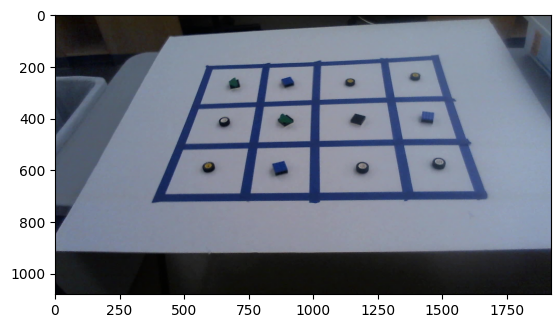

In [5]:
image=imread('images/2011-11-15 - Board Images/output24.jpg')
imshow(image)

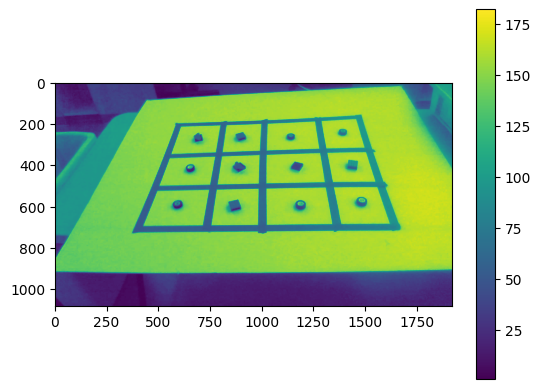

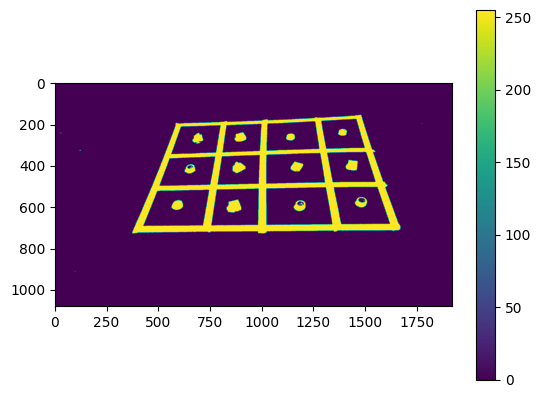

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

figure()
imshow(gray)
colorbar()

# thresholding
threshold_im=((gray<120)*255).astype(np.uint8)

h, w = threshold_im.shape[:2]

cv2.floodFill(threshold_im,None,(0,0),0)
cv2.floodFill(threshold_im,None,(w-1,0),0)
cv2.floodFill(threshold_im,None,(w-1,h-1),0)
cv2.floodFill(threshold_im,None,(0,h-1),0)    

figure()
imshow(threshold_im)
colorbar()


In [7]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(threshold_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Find the contour that best matches the game board
board_contour = None
for contour in contours:
    # Approximate the contour to reduce the number of points
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Check if this contour has 4 points (for a rectangular shape)
    if len(approx) == 4:
        board_contour = approx
        break

if board_contour is not None:
    # Sort the corners in the order: top-left, top-right, bottom-right, bottom-left
    corners = np.array([point[0] for point in board_contour])
    sum_pts = corners.sum(axis=1)
    diff_pts = np.diff(corners, axis=1)
    top_left = corners[np.argmin(sum_pts)]
    bottom_right = corners[np.argmax(sum_pts)]
    top_right = corners[np.argmin(diff_pts)]
    bottom_left = corners[np.argmax(diff_pts)]
    ordered_corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")
else:
    print("Could not find a rectangular contour in the image.")    
    ordered_corners=None


corners=ordered_corners

array([[ 585.,  198.],
       [1477.,  158.],
       [1670.,  696.],
       [ 373.,  728.]], dtype=float32)

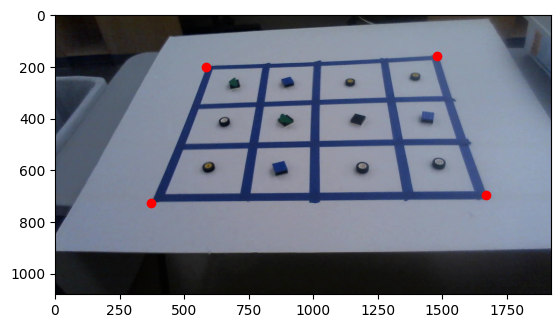

In [8]:
imshow(image)

# first column = x, second column=y  (could easily have been row,col)
plot(corners[:,0],corners[:,1],'ro')
corners

In [9]:
top_left, top_right, bottom_right, bottom_left=corners
# Define the width and height of the new "top-down" view
width = int(max(
    np.linalg.norm(bottom_right - bottom_left),
    np.linalg.norm(top_right - top_left)
))
height = int(max(
    np.linalg.norm(top_right - bottom_right),
    np.linalg.norm(top_left - bottom_left)
))

# Define the destination points for the perspective transform
destination_corners = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype="float32")

# Compute the perspective transform matrix
matrix = cv2.getPerspectiveTransform(corners, destination_corners)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(image, matrix, (width, height))


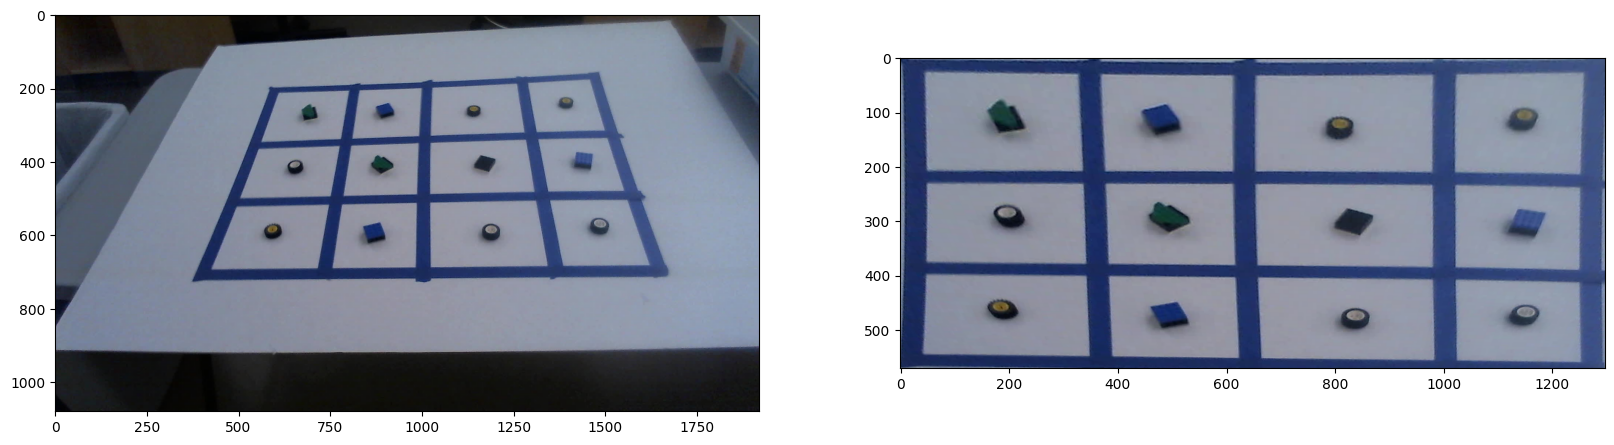

In [11]:
figure(figsize=(20,8))
subplot(1,2,1)
imshow(image)

subplot(1,2,2)
imshow(warped_image)